# Mean Reverse Research 1

This research will examing the condition when mean reverse happening and also we are interested in the during of mean reverse happens and the matrics it happens (how far from the moving average)

Important Concepts:
    1. PM-Delta: The difference between price and previous n-day moving average; 
    2. P-Delta: The difference between current price and previouse n days price;
    3. Q500US: A universe of securities that defined as easy tradable 500 securities [reference](https://www.quantopian.com/posts/the-q500us-and-q1500us.)
    4. sma: Simple moving average;
    5. lsma: Simple moving average of yesterday

### Dependent Variable

Up or Down: Positive value or Negative value of the p-delta

## Independent Variables

PM-Delta: Difference between current price and the 30 days moving average.

## Data

In this research, we are going to select a universe of securities to test mean reverse theory. We will just consider stocks in the Q500US or Q1500US universe. 

#### Q1500US universe mask

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

In [3]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.classifiers.morningstar import Sector


SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
}


class NDayPDelta(CustomFactor):
    """
    Calculate the n day p delta, n = window_length - 1.
    """
    
    def compute(self, today, assets, out, close):
        out[:] = close[1] - close[0]

        
class LSimpleMovingAverage(SimpleMovingAverage):
    """
    Average Value of an arbitrary column

    **Default Inputs**: None

    **Default Window Length**: None
    """
    # numpy's nan functions throw warnings when passed an array containing only
    # nans, but they still returns the desired value (nan), so we ignore the
    # warning.

    def compute(self, today, assets, out, data):
        out[:] = np.nanmean(data[0:self.window_length - 1], axis=0)

        
class LastClose(CustomFactor):
    """
    The factor to call the last close price.
    """
    def compute(self, today, assets, out, data):
        out[:] = data[0]

        
def get_data(start, end):
    """
    Get the USEquityPricing data masked by the Q1500US universe.
    Args:
        start: start date interested in.
        end: end date interested in.
    """
    pipe = Pipeline(
        columns={'close': USEquityPricing.close.latest,
                 'last_close': LastClose(inputs=[USEquityPricing.close], window_length=2),
                 'lsma10': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=11),
                 'lsma15': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=16),
                 'lsma20': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=21),
                 'lsma25': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=26),
                 'lsma30': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=31),
                 'sma30': SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30),
                 'pdelta1': NDayPDelta(inputs=[USEquityPricing.close], window_length=2),
                 'sector': Sector()},
        screen=Q1500US()
    )

    research_range = (start, end)
    data = run_pipeline(pipe, *research_range)
    
    return data

data = get_data('2008-01-01', '2008-01-01').head()
data

close  last_close    lsma10  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    36.54       36.81   35.7972   
                          Equity(24 [AAPL])  198.08      199.78  191.7642   
                          Equity(62 [ABT])    56.02       57.16   57.5550   
                          Equity(67 [ADSK])   49.75       50.19   50.1130   
                          Equity(76 [TAP])    51.64       52.12   51.8885   

                                                 lsma15     lsma20  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    36.135467   36.02910   
                          Equity(24 [AAPL])  191.827467  189.68860   
                          Equity(62 [ABT])    57.823333   57.78350   
                          Equity(67 [ADSK])   49.864667   49.35200   
                          Equity(76 [TAP])    52.458333   52.97625   

                                                 lsma25      lsma30  pdelta1  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    35.939280   35.891067    -0.27   
                          Equity(24 [AAPL])  187.083400  183.624867    -1.70   
                          Equity(62 [ABT])    57.388400   56.980333    -1.14   
                          Equity(67 [ADSK])   48.692000   48.298667    -0.44   
                          Equity(76 [TAP])    52.866496   52.644375    -0.48   

                                             sector       sma30  
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])      101   35.897067  
                          Equity(24 [AAPL])     311  184.752667  
                          Equity(62 [ABT])      206   57.032000  
                          Equity(67 [ADSK])     311   48.370000  
                          Equity(76 [TAP])      205   52.626050

## Step 1. Correlation between P-Delta and PM-Delta

### Fetch and validate data

In [4]:
data1 = get_data(start = '2014-01-01', end = '2017-01-01')

data1.head()

close  last_close    lsma10  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])    10.63       10.53   10.1175   
                          Equity(24 [AAPL])  561.16      554.50  557.2660   
                          Equity(62 [ABT])    38.34       38.40   37.8840   
                          Equity(67 [ADSK])   50.32       49.58   48.7840   
                          Equity(76 [TAP])    56.15       55.76   54.9740   

                                                 lsma15     lsma20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.894333    9.77170   
                          Equity(24 [AAPL])  558.746667  559.58850   
                          Equity(62 [ABT])    37.496000   37.50050   
                          Equity(67 [ADSK])   48.028000   47.51350   
                          Equity(76 [TAP])    54.691333   54.50925   

                                                 lsma25      lsma30  pdelta1  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.727560    9.615300     0.10   
                          Equity(24 [AAPL])  554.830800  548.996333     6.66   
                          Equity(62 [ABT])    37.639600   37.731500    -0.06   
                          Equity(67 [ADSK])   47.100000   46.436000     0.74   
                          Equity(76 [TAP])    54.221354   54.074253     0.39   

                                             sector       sma30  
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      101    9.668967  
                          Equity(24 [AAPL])     311  550.203667  
                          Equity(62 [ABT])      206   37.740833  
                          Equity(67 [ADSK])     311   46.643000  
                          Equity(76 [TAP])      205   54.152720

In [5]:
data1.loc['2014-01-03'].head()

close  last_close   lsma10  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])    10.529       10.63   10.224   
                          Equity(24 [AAPL])  553.230      561.16  557.635   
                          Equity(62 [ABT])    38.240       38.34   38.064   
                          Equity(67 [ADSK])   49.250       50.32   49.098   
                          Equity(76 [TAP])    55.220       56.15   55.215   

                                                 lsma15     lsma20     lsma25  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.971667    9.82525    9.78316   
                          Equity(24 [AAPL])  558.384000  560.08150  556.48960   
                          Equity(62 [ABT])    37.571333   37.51000   37.64320   
                          Equity(67 [ADSK])   48.263333   47.75800   47.27840   
                          Equity(76 [TAP])    54.764667   54.68975   54.33460   

                                                 lsma30  pdelta1  sector  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.668967   -0.101     101   
                          Equity(24 [AAPL])  550.203667   -7.930     311   
                          Equity(62 [ABT])    37.740833   -0.100     206   
                          Equity(67 [ADSK])   46.643000   -1.070     311   
                          Equity(76 [TAP])    54.152720   -0.930     205   

                                                  sma30  
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.721933  
                          Equity(24 [AAPL])  551.356333  
                          Equity(62 [ABT])    37.750667  
                          Equity(67 [ADSK])   46.840667  
                          Equity(76 [TAP])    54.204825

In [6]:
data1['pm_delta30'] = data1.last_close - data1.lsma30
data1['pm_delta25'] = data1.last_close - data1.lsma25
data1['pm_delta20'] = data1.last_close - data1.lsma20
data1['pm_delta15'] = data1.last_close - data1.lsma15
data1['pm_delta10'] = data1.last_close - data1.lsma10

data1.head()

close  last_close    lsma10  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])    10.63       10.53   10.1175   
                          Equity(24 [AAPL])  561.16      554.50  557.2660   
                          Equity(62 [ABT])    38.34       38.40   37.8840   
                          Equity(67 [ADSK])   50.32       49.58   48.7840   
                          Equity(76 [TAP])    56.15       55.76   54.9740   

                                                 lsma15     lsma20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.894333    9.77170   
                          Equity(24 [AAPL])  558.746667  559.58850   
                          Equity(62 [ABT])    37.496000   37.50050   
                          Equity(67 [ADSK])   48.028000   47.51350   
                          Equity(76 [TAP])    54.691333   54.50925   

                                                 lsma25      lsma30  pdelta1  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.727560    9.615300     0.10   
                          Equity(24 [AAPL])  554.830800  548.996333     6.66   
                          Equity(62 [ABT])    37.639600   37.731500    -0.06   
                          Equity(67 [ADSK])   47.100000   46.436000     0.74   
                          Equity(76 [TAP])    54.221354   54.074253     0.39   

                                             sector       sma30  pm_delta30  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      101    9.668967    0.914700   
                          Equity(24 [AAPL])     311  550.203667    5.503667   
                          Equity(62 [ABT])      206   37.740833    0.668500   
                          Equity(67 [ADSK])     311   46.643000    3.144000   
                          Equity(76 [TAP])      205   54.152720    1.685747   

                                             pm_delta25  pm_delta20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     0.802440     0.75830   
                          Equity(24 [AAPL])   -0.330800    -5.08850   
                          Equity(62 [ABT])     0.760400     0.89950   
                          Equity(67 [ADSK])    2.480000     2.06650   
                          Equity(76 [TAP])     1.538646     1.25075   

                                             pm_delta15  pm_delta10  
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     0.635667      0.4125  
                          Equity(24 [AAPL])   -4.246667     -2.7660  
                          Equity(62 [ABT])     0.904000      0.5160  
                          Equity(67 [ADSK])    1.552000      0.7960  
                          Equity(76 [TAP])     1.068667      0.7860

### Preprocess

Filter out stocks that has less than 30 days record in the data.

In [7]:
# Flat the table, so we just have timestamp index and set asset to a new column
data1 = data1.reset_index().rename(columns = {'level_0': 'date', 'level_1': 'asset'}).set_index('date')
data1.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(2 [ARNC]),10.63,10.53,10.1175,9.894333,9.77170,9.727560,9.615300,0.10,101,9.668967,0.914700,0.802440,0.75830,0.635667,0.4125
2014-01-02 00:00:00+00:00,Equity(24 [AAPL]),561.16,554.50,557.2660,558.746667,559.58850,554.830800,548.996333,6.66,311,550.203667,5.503667,-0.330800,-5.08850,-4.246667,-2.7660
2014-01-02 00:00:00+00:00,Equity(62 [ABT]),38.34,38.40,37.8840,37.496000,37.50050,37.639600,37.731500,-0.06,206,37.740833,0.668500,0.760400,0.89950,0.904000,0.5160
2014-01-02 00:00:00+00:00,Equity(67 [ADSK]),50.32,49.58,48.7840,48.028000,47.51350,47.100000,46.436000,0.74,311,46.643000,3.144000,2.480000,2.06650,1.552000,0.7960
2014-01-02 00:00:00+00:00,Equity(76 [TAP]),56.15,55.76,54.9740,54.691333,54.50925,54.221354,54.074253,0.39,205,54.152720,1.685747,1.538646,1.25075,1.068667,0.7860


In [8]:
# Count number of records for each stock
asset_record_count = pd.DataFrame(data1.groupby('asset').size().rename('counts')).reset_index()
good_assets = asset_record_count[asset_record_count.counts > 30]


In [9]:
# Select good_assets in the original data
good_assets_mask = data1.asset.isin(good_assets.asset)
data = data1[good_assets_mask]
data.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(2 [ARNC]),10.63,10.53,10.1175,9.894333,9.77170,9.727560,9.615300,0.10,101,9.668967,0.914700,0.802440,0.75830,0.635667,0.4125
2014-01-02 00:00:00+00:00,Equity(24 [AAPL]),561.16,554.50,557.2660,558.746667,559.58850,554.830800,548.996333,6.66,311,550.203667,5.503667,-0.330800,-5.08850,-4.246667,-2.7660
2014-01-02 00:00:00+00:00,Equity(62 [ABT]),38.34,38.40,37.8840,37.496000,37.50050,37.639600,37.731500,-0.06,206,37.740833,0.668500,0.760400,0.89950,0.904000,0.5160
2014-01-02 00:00:00+00:00,Equity(67 [ADSK]),50.32,49.58,48.7840,48.028000,47.51350,47.100000,46.436000,0.74,311,46.643000,3.144000,2.480000,2.06650,1.552000,0.7960
2014-01-02 00:00:00+00:00,Equity(76 [TAP]),56.15,55.76,54.9740,54.691333,54.50925,54.221354,54.074253,0.39,205,54.152720,1.685747,1.538646,1.25075,1.068667,0.7860


### Run Coorelation

In [11]:
data.loc[:, 
         ('pdelta1', 'sma30', 'pm_delta30', 'pm_delta25', 'pm_delta20','pm_delta15', 'pm_delta10')].corr()

,pdelta1,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
pdelta1,1.000000,0.007448,-0.012459,-0.012141,-0.012602,-0.009770,-0.009055
sma30,0.007448,1.000000,0.075211,0.063321,0.051850,0.039902,0.027885
pm_delta30,-0.012459,0.075211,1.000000,0.988043,0.948881,0.875518,0.755822
pm_delta25,-0.012141,0.063321,0.988043,1.000000,0.982315,0.923337,0.808966
pm_delta20,-0.012602,0.051850,0.948881,0.982315,1.000000,0.971614,0.873779
pm_delta15,-0.009770,0.039902,0.875518,0.923337,0.971614,1.000000,0.947870
pm_delta10,-0.009055,0.027885,0.755822,0.808966,0.873779,0.947870,1.000000


In [12]:
assets_corr = data.groupby('asset').corr()
assets_corr = assets_corr.loc[:, ('sma30', 'pm_delta30', 'pm_delta25', 'pm_delta20',
                                  'pm_delta15', 'pm_delta10')].reset_index().groupby('asset').nth(7)
assets_corr.head()

,level_1,pm_delta10,pm_delta15,pm_delta20,pm_delta25,pm_delta30,sma30
asset,,,,,,,
Equity(2 [ARNC]),pdelta1,0.007970,-0.033302,-0.055749,-0.050893,-0.043424,-0.072678
Equity(24 [AAPL]),pdelta1,0.056907,0.007019,0.014961,0.029938,0.033528,0.086886
Equity(41 [ARCB]),pdelta1,-0.044572,-0.058633,-0.075225,-0.078209,-0.079200,-0.054929
Equity(53 [ABMD]),pdelta1,-0.055310,-0.066701,-0.076942,-0.077401,-0.068628,-0.053487
Equity(62 [ABT]),pdelta1,-0.012160,-0.002242,0.003902,-0.001304,-0.001993,-0.075582


Sort the mean of all pm-delta values and take the first 100 assets as high correlated stock.

Notes: Here high correlated stock means they have a negative correlation but the absolute value of the correlation is large, that's because mean reverse should reflect as negative in the correlation

In [99]:
assets_corr['cor_avg'] = assets_corr[['pm_delta10', 'pm_delta15', 'pm_delta20', 
                                      'pm_delta25', 'pm_delta30']].mean(axis=1)
high_corr_assets = assets_corr.sort_values(['cor_avg']).head(100)
high_corr_assets.head()

low_corr_assets = assets_corr.sort_values(['cor_avg']).tail(100)
low_corr_assets.head()

,level_1,pm_delta10,pm_delta15,pm_delta20,pm_delta25,pm_delta30,sma30,cor_avg
asset,,,,,,,,
Equity(40445 [LPLA]),pdelta1,0.037842,0.056704,0.059737,0.063187,0.064834,-0.064477,0.056461
Equity(16059 [NUS]),pdelta1,0.081043,0.063651,0.059016,0.045628,0.036633,-0.177136,0.057194
Equity(510 [ARG]),pdelta1,0.082053,0.058204,0.052609,0.048258,0.044895,-0.045560,0.057204
Equity(3431 [HA]),pdelta1,0.066674,0.066540,0.054686,0.052149,0.046104,-0.005329,0.057231
Equity(20776 [PLUG]),pdelta1,0.087117,0.069695,0.053566,0.041995,0.034721,-0.108618,0.057419


Get the top 50 securities that has strongest mean reverse effect in 30 days

In [14]:
import matplotlib.pyplot as plt

In [15]:
data.asset[0]

Equity(2, symbol=u'ARNC', asset_name=u'ARCONIC INC', exchange=u'NYSE', start_date=Timestamp('2002-01-01 00:00:00+0000', tz='UTC'), end_date=Timestamp('2017-06-13 00:00:00+0000', tz='UTC'), first_traded=None, auto_close_date=Timestamp('2017-06-16 00:00:00+0000', tz='UTC'), exchange_full=u'NEW YORK STOCK EXCHANGE')

Here we just take two examples out to do some research on their trend and pm-values

In [16]:
t = data[data.asset == symbols('MSGN')]
t.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(39171 [MSGN]),57.58,57.76,55.794,55.686333,55.76400,55.80048,55.865067,-0.18,102,55.886733,1.894933,1.95952,1.99600,2.073667,1.966
2014-01-03 00:00:00+00:00,Equity(39171 [MSGN]),57.48,57.58,56.069,55.728333,55.84800,55.87160,55.886733,-0.10,102,55.929733,1.693267,1.70840,1.73200,1.851667,1.511
2014-01-06 00:00:00+00:00,Equity(39171 [MSGN]),57.84,57.48,56.318,55.823667,55.92375,55.95360,55.929733,0.36,102,55.990067,1.550267,1.52640,1.55625,1.656333,1.162
2014-01-07 00:00:00+00:00,Equity(39171 [MSGN]),57.69,57.84,56.616,56.001667,56.02925,56.03720,55.990067,-0.15,102,56.053400,1.849933,1.80280,1.81075,1.838333,1.224
2014-01-08 00:00:00+00:00,Equity(39171 [MSGN]),57.11,57.69,56.884,56.227333,56.10625,56.09240,56.053400,-0.58,102,56.090400,1.636600,1.59760,1.58375,1.462667,0.806


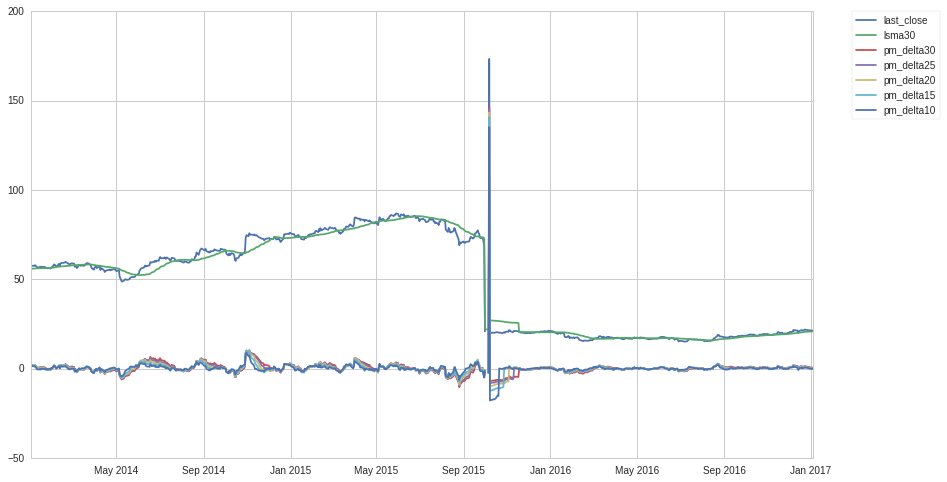

In [17]:
plt.plot(t.last_close)
plt.plot(t.lsma30)
plt.plot(t.pm_delta30)
plt.plot(t.pm_delta25)
plt.plot(t.pm_delta20)
plt.plot(t.pm_delta15)
plt.plot(t.pm_delta10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [101]:
t.loc['2015-09-25':'2015-10-02', ]

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2015-09-25 00:00:00+00:00,Equity(39171 [MSGN]),73.110000,73.090000,74.590400,73.708267,72.936200,72.819760,73.578800,0.020000,102,73.476467,-0.488800,0.270240,0.153800,-0.618267,-1.50040
2015-09-28 00:00:00+00:00,Equity(39171 [MSGN]),70.810000,73.110000,74.619400,73.855600,73.085200,72.686160,73.476467,-2.300000,102,73.277800,-0.366467,0.423840,0.024800,-0.745600,-1.50940
2015-09-29 00:00:00+00:00,Equity(39171 [MSGN]),68.790000,70.810000,74.395400,73.836933,73.068700,72.582160,73.277800,-2.020000,102,73.002800,-2.467800,-1.772160,-2.258700,-3.026933,-3.58540
2015-09-30 00:00:00+00:00,Equity(39171 [MSGN]),68.830000,68.790000,73.911400,73.674933,72.955700,72.447360,73.002800,0.040000,102,72.673800,-4.212800,-3.657360,-4.165700,-4.884933,-5.12140
2015-10-01 00:00:00+00:00,Equity(39171 [MSGN]),21.782513,20.806139,22.138119,22.191482,22.029388,21.896824,21.968054,0.976374,102,21.906389,-1.161915,-1.090685,-1.223249,-1.385343,-1.33198


A company split events happend in Sep 2015 [News Articles](http://www.reuters.com/finance/stocks/MSGN.N/key-developments/article/3272520)

In [19]:
aapl = data1[data1.asset == symbols('AAPL')]
aapl.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(24 [AAPL]),561.160,554.500,557.2660,558.746667,559.58850,554.83080,548.996333,6.660,311,550.203667,5.503667,-0.33080,-5.08850,-4.246667,-2.7660
2014-01-03 00:00:00+00:00,Equity(24 [AAPL]),553.230,561.160,557.6350,558.384000,560.08150,556.48960,550.203667,-7.930,311,551.356333,10.956333,4.67040,1.07850,2.776000,3.5250
2014-01-06 00:00:00+00:00,Equity(24 [AAPL]),541.040,553.230,557.4600,557.556667,559.42400,557.66880,551.356333,-12.190,311,552.074333,1.873667,-4.43880,-6.19400,-4.326667,-4.2300
2014-01-07 00:00:00+00:00,Equity(24 [AAPL]),543.949,541.040,556.4890,556.216667,558.23300,557.96640,552.074333,2.909,311,553.038967,-11.034333,-16.92640,-17.19300,-15.176667,-15.4490
2014-01-08 00:00:00+00:00,Equity(24 [AAPL]),540.030,543.949,556.4389,555.101933,557.02545,557.88916,553.038967,-3.919,311,553.672633,-9.089967,-13.94016,-13.07645,-11.152933,-12.4899


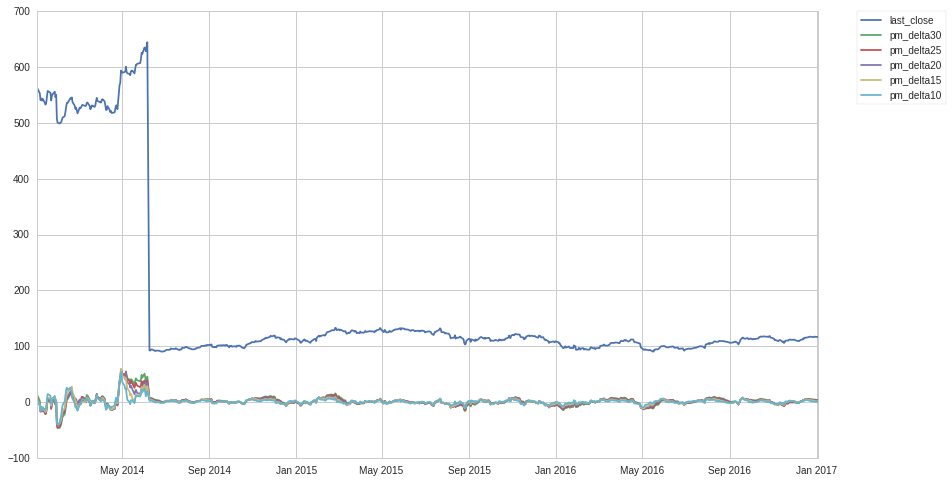

In [20]:
plt.plot(aapl.last_close)
plt.plot(aapl.pm_delta30)
plt.plot(aapl.pm_delta25)
plt.plot(aapl.pm_delta20)
plt.plot(aapl.pm_delta15)
plt.plot(aapl.pm_delta10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [102]:
# Check the steep drop area in the plot
aapl.loc['2014-06-01':'2014-06-10', :]

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-06-02 00:00:00+00:00,Equity(24 [AAPL]),633.00000,635.280000,610.804500,604.135667,600.852026,596.685349,584.469081,-2.280000,311,588.365998,50.810919,38.594651,34.427974,31.144333,24.475500
2014-06-03 00:00:00+00:00,Equity(24 [AAPL]),628.50000,633.000000,615.222500,607.127667,603.098253,599.420690,588.365998,-4.500000,311,591.913529,44.634002,33.579310,29.901747,25.872333,17.777500
2014-06-04 00:00:00+00:00,Equity(24 [AAPL]),637.54000,628.500000,618.326000,609.991667,605.065781,601.808965,591.913529,9.040000,311,595.557869,36.586471,26.691035,23.434219,18.508333,10.174000
2014-06-05 00:00:00+00:00,Equity(24 [AAPL]),644.82000,637.540000,621.639000,612.976333,607.063167,603.679709,595.557869,7.280000,311,599.427306,41.982131,33.860291,30.476833,24.563667,15.901000
2014-06-06 00:00:00+00:00,Equity(24 [AAPL]),647.35000,644.820000,625.660000,616.384333,609.747250,605.906532,599.427306,2.530000,311,603.611458,45.392694,38.913468,35.072750,28.435667,19.160000
2014-06-09 00:00:00+00:00,Equity(24 [AAPL]),92.22613,92.480421,89.968514,88.566105,87.524929,86.906027,86.231933,-0.254291,311,86.617434,6.248488,5.574394,4.955492,3.914316,2.511907
2014-06-10 00:00:00+00:00,Equity(24 [AAPL]),93.70000,92.226130,90.514810,89.106592,87.935294,87.234574,86.617434,1.473870,311,87.032174,5.608697,4.991557,4.290836,3.119539,1.711320


It turns out apple did a stock split in June 2014 [apple stock split](http://money.cnn.com/2014/06/06/investing/apple-stock-split/index.html)

### Step 2: Check the distribution of sectors

In [22]:
def calculate_sector_counts(sectors):
    counts = (sectors.groupby('sector').size())

    # Replace numeric sector codes with human-friendly names.
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts


def plot_sector_counts(sector_counts):
    ax = sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
    )
    ax.set_title('High PM-Delta vs. P-Delta Correlation Sector Breakdown', fontsize=18)
    ax.set_ylabel('')  # This overwrites default ylabel, which is the string None :(.

In [93]:
# Select the asset sector from the top correlated asset
high_corr_asset = pd.merge(high_corr_assets.reset_index().iloc[:, 0:1], 
                           data1.loc[:, ['asset', 'sector']], 
                           how='left', on = 'asset').groupby('asset').first()

In [94]:
sector_counts = calculate_sector_counts(high_corr_asset)
sector_counts

Basic Materials            5
Consumer Cyclical         15
Financial Services         7
Real Estate                9
Consumer Defensive         7
Healthcare                17
Utilities                  3
Communication Services     2
Energy                     1
Industrials               13
Technology                21
dtype: int64

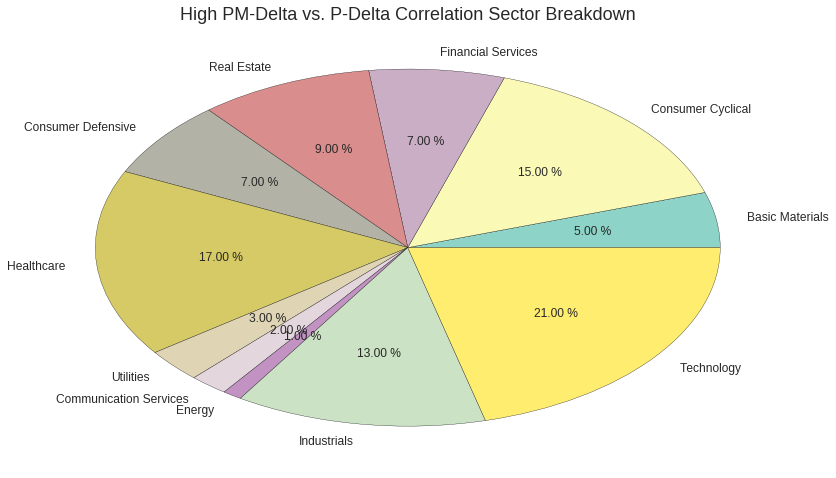

In [95]:
plot_sector_counts(sector_counts)

## Classification Model

Take apple's stock as an example and building a SVM classification model to check

In [81]:
def up_or_down(model_data, x_columns=['pm_delta30', 'pm_delta25', 'pm_delta20', 'pm_delta15', 'pm_delta10'], 
               y_column=['pdelta1'], test_ratio=0.2, probability=False):
    """
    Train a classification model to predict the next day's stock price up or down.
    """
    from sklearn import svm
    from sklearn import metrics
    model_data = model_data.reset_index()
    n_row_train = np.floor((1 - test_ratio) * model_data.shape[0])
#     print(n_row_train)
    x_train = model_data.ix[0:n_row_train - 1, x_columns].as_matrix() 
    x_test = model_data.ix[n_row_train:, x_columns].as_matrix()
    y_train = model_data.ix[0:n_row_train - 1, y_column].as_matrix().ravel()
    y_test = model_data.ix[n_row_train:, y_column].as_matrix().ravel()
    
#     print x_train.shape
#     print y_train.shape
    # Convert y_train and y_test to binary variable
    y_train = np.where(y_train > 0, 1, 0)
    y_test = np.where(y_test > 0, 1, 0)
    
    clf = svm.SVC(kernel='rbf', probability=probability)
    model = clf.fit(x_train, y_train)
    
    test_predict = clf.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, test_predict)
    
    return {'model': model, 'test_accuracy': accuracy}


In [82]:
# Predict apple
r = up_or_down(aapl)
print r['test_accuracy']
print r['model']

0.506578947368
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


Next step, we will take the top 100 correlation

In [100]:
# Predict on high correlated assets
# Select the asset sector from the top correlated asset
high_corr_assets = pd.merge(high_corr_assets.reset_index().iloc[:, 0:1], 
                            data.loc[:, ['pm_delta30', 'pm_delta25', 'pm_delta20', 
                                         'pm_delta15', 'pm_delta10', 'pdelta1', 'asset']], 
                            how='left', on = 'asset')

# high_corr_assets.head()
low_corr_assets = pd.merge(low_corr_assets.reset_index().iloc[:, 0:1], 
                            data.loc[:, ['pm_delta30', 'pm_delta25', 'pm_delta20', 
                                         'pm_delta15', 'pm_delta10', 'pdelta1', 'asset']], 
                            how='left', on = 'asset')


Generate two results list, one for high correlated assets the other is for low correlated assets.

In [103]:
unique_high_corr_assets = high_corr_assets.asset.unique()
unique_low_corr_assets = low_corr_assets.asset.unique()

r_list_high_corr = []
r_list_low_corr = []

for asset in unique_high_corr_assets:
    df = data1[data1.asset == asset]
    try:
        r = up_or_down(df)
        r_list_high_corr.append({'asset': asset, 'test_accuracy': r['test_accuracy']})
    except:
        df['pdelta1'].describe()
#     print '{}({}) test accuracy is {}\n'.format(asset.symbol, asset.asset_name, r['test_accuracy'])

for asset in unique_low_corr_assets:
    df = data1[data1.asset == asset]
    try:
        r = up_or_down(df)
        r_list_low_corr.append({'asset': asset, 'test_accuracy': r['test_accuracy']})
    except:
        df['pdelta1'].describe()
#     print '{}({}) test accuracy is {}\n'.format(asset.symbol, asset.asset_name, r['test_accuracy'])


In [105]:
r_high_corr_df = pd.DataFrame(r_list_high_corr)
r_high_corr_df.sort_values(['test_accuracy'], ascending=False).head()

,asset,test_accuracy
32,Equity(6104 [FIZZ]),0.909091
38,Equity(4355 [LANC]),0.771429
22,Equity(49515 [RACE]),0.769231
9,Equity(7845 [MUX]),0.769231
44,Equity(42260 [JIVE]),0.769231


In [106]:
r_low_corr_df = pd.DataFrame(r_list_low_corr)
r_low_corr_df.sort_values(['test_accuracy'], ascending=False).head()

,asset,test_accuracy
88,Equity(38827 [OMER]),0.692308
21,Equity(31032 [HK]),0.687500
46,Equity(7697 [UBSI]),0.684211
4,Equity(20776 [PLUG]),0.681818
91,Equity(41242 [ARCO]),0.680000


Below is a comparision of the test_accuracy between high correlated stocks vs. low correlated stocks.

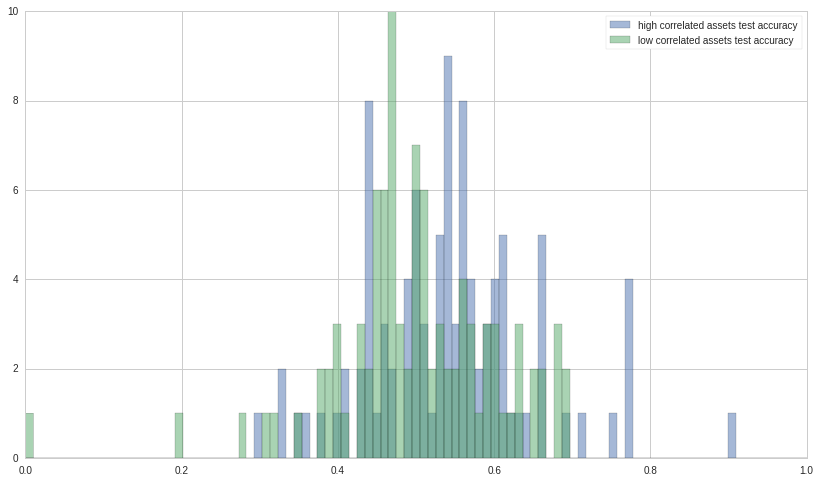

In [108]:
from matplotlib import pyplot

high_corr_assets = r_high_corr_df.test_accuracy
low_corr_assets = r_low_corr_df.test_accuracy

bins = np.linspace(0, 1, 100)

pyplot.hist(high_corr_assets, bins, alpha=0.5, label='high correlated assets test accuracy')
pyplot.hist(low_corr_assets, bins, alpha=0.5, label='low correlated assets test accuracy')
pyplot.legend(loc='upper right')
pyplot.show()